In [ ]:
!nvidia-smi

Mon May 15 19:32:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers
!pip install pytorch_lightning
!pip install sentencepiece datasets seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wh

In [ ]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl


from transformers import (
    AdamW,
    MT5ForConditionalGeneration,
    T5ForConditionalGeneration,
    T5Tokenizer,
    AutoTokenizer,
    get_linear_schedule_with_warmup
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [ ]:
class T5FineTuner(pl.LightningModule):
    def __init__(self, hparam):
        super(T5FineTuner, self).__init__()
        self.hparam = hparam
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.automatic_optimization=False
        self.loss_each_epoch_training = []
        self.loss_each_epoch_testing = [] 

        self.model = T5ForConditionalGeneration.from_pretrained(
            hparam.model_name_or_path)
        self.tokenizer = AutoTokenizer.from_pretrained(
            hparam.model_name_or_path
        )
        self.save_hyperparameters()

    def is_logger(self):
        return True

    def forward(
        self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
    ):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=lm_labels,
        )

    def _step(self, batch):
        lm_labels = batch["target_ids"]
        lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            lm_labels=lm_labels,
            decoder_attention_mask=batch['target_mask']
        )

        loss = outputs[0]

        return loss

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)
        self.training_step_outputs.append(loss)
        tensorboard_logs = {"train_loss": loss}
        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()
        self.log("val_loss", loss)
        return {"loss": loss, "log": tensorboard_logs}

    def on_train_epoch_end(self):
        epoch_average = torch.stack(self.training_step_outputs).mean()
        self.loss_each_epoch_training.append(epoch_average)
        self.log("training_loss", epoch_average)
        self.training_step_outputs.clear()  

    def validation_step(self, batch, batch_idx):
        loss = self._step(batch)
        self.validation_step_outputs.append(loss)
        self.log("val_loss", loss)
        return {"val_loss": loss}

    def on_validation_epoch_end(self):
        epoch_average = torch.stack(self.validation_step_outputs).mean()
        self.loss_each_epoch_testing.append(epoch_average)
        self.log("val_loss", epoch_average)
        self.validation_step_outputs.clear()  

    def configure_optimizers(self):
        "Prepare optimizer and schedule (linear warmup and decay)"

        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparam.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters,
                          lr=self.hparam.learning_rate, eps=self.hparam.adam_epsilon)
        self.opt = optimizer
        return [optimizer]

    def optimizer_step(self,
                       epoch=None,
                       batch_idx=None,
                       optimizer=None,
                       optimizer_idx=None,
                       optimizer_closure=None,
                       on_tpu=None,
                       using_native_amp=None,
                       using_lbfgs=None
                       ):
        optimizer = optimizer.optimizer
        optimizer.step(closure=optimizer_closure)
        optimizer.zero_grad()
        self.lr_scheduler.step()

    def get_tqdm_dict(self):
        tqdm_dict = {"loss": "{:.3f}".format(
            self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

        return tqdm_dict

    def train_dataloader(self):
        train_dataset = get_dataset(
            tokenizer=self.tokenizer, type_path="train.tsv", args=self.hparam)
        dataloader = DataLoader(train_dataset, batch_size=self.hparam.train_batch_size,
                                drop_last=True, shuffle=True, num_workers=2)
        t_total = (
            (len(dataloader.dataset) //
             (self.hparam.train_batch_size * max(1, self.hparam.n_gpu)))
            // self.hparam.gradient_accumulation_steps
            * float(self.hparam.num_train_epochs)
        )
        scheduler = get_linear_schedule_with_warmup(
            self.opt, num_warmup_steps=self.hparam.warmup_steps, num_training_steps=t_total
        )
        self.lr_scheduler = scheduler
        return dataloader

    def val_dataloader(self):
        val_dataset = get_dataset(
            tokenizer=self.tokenizer, type_path="dev.tsv", args=self.hparam)
        return DataLoader(val_dataset, batch_size=self.hparam.eval_batch_size, num_workers=2)

In [ ]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))

In [ ]:
args_dict = dict(
    data_dir="", 
    output_dir="/sample_data", 
    model_name_or_path='t5-small',
    tokenizer_name_or_path='t5-small',
    max_seq_length=1028,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=3,
    gradient_accumulation_steps=16,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=True, 
    opt_level='O1',
    max_grad_norm=1, 
    seed=42,
)

In [ ]:
def process_data(file):
      f = open(file)
      data = []
      sentences = []
      labels = []
      sentence = []
      label= []
      for line in f:
                  l=line.split('\t')
                  if len(l)==0 or l[0]=="\n" or l[0]=="  \n":
                      if len(sentence) > 0:
                          sentences.append(sentence)
                          labels.append(label)
                          sentence = []
                          label = []
                      continue

                  sentence.append(l[0])
                  label.append(l[1].strip())

      if len(sentence) >0:
                  print("printing data value:", sentence, label)
                  sentences.append(sentence)
                  labels.append(label)
                  sentence = []
                  label = []
      return pd.DataFrame({'sentence': sentences, 'labels':labels})

In [ ]:
class Dataset(Dataset):
  def __init__(self, tokenizer, dataset, max_len=512):

    self.data = dataset
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.tokenizer.max_length = max_len
    self.tokenizer.model_max_length = max_len
    self.inputs = []
    self.targets = []

    self._build()
  
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  
    target_mask = self.targets[index]["attention_mask"].squeeze()  

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
  
  def _build(self):
    print(self.data)
    for idx in range(len(self.data)):
      new_target = []
      sentences = self.data["sentence"][idx]
      labels = self.data["labels"][idx]
      new_labels = ['']*len(sentences)
      for i in range(len(sentences)):
               if(labels[i]=='i'):
                  new_labels[i] = sentences[i]+"#"
               else:
                  new_labels[i] = sentences[i]
      input_, target = " ".join(self.data["sentence"][idx]), " ".join(new_labels)     
      
      input_ = input_.lower() + ' </s>'
      target = target.lower() + " </s>"

   
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [input_], max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt"
      )

      tokenized_targets = self.tokenizer.batch_encode_plus(
          [target],max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt"
      )

      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")

print(tokenizer)

input_dataset = Dataset(tokenizer=tokenizer, dataset=process_data("train.tsv"))

T5TokenizerFast(name_or_path='t5-small', vocab_size=32100, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_42>', '<extra_id_43>', '<extra_i

In [ ]:
for i in range(len(input_dataset)):
    _ = input_dataset[i]

In [ ]:
data = input_dataset[0]

print(tokenizer.decode(data["source_ids"], skip_special_tokens=False))
print(tokenizer.decode(data["target_ids"], skip_special_tokens=False))

dear sir or madam,</s></s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

In [ ]:
args = argparse.Namespace(**args_dict)
model = T5FineTuner(args)

In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename=args.output_dir+"/checkpoint.pth", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    max_epochs=args.num_train_epochs,
    precision= 16 if args.fp_16 else 32,
    callbacks=[LoggingCallback(),checkpoint_callback],
)

In [ ]:
def get_dataset(tokenizer, type_path, args):
    tokenizer.max_length = args.max_seq_length
    tokenizer.model_max_length = args.max_seq_length
    dataset = Dataset(tokenizer=tokenizer, dataset=process_data(type_path))
    return dataset

In [ ]:
trainer = pl.Trainer(**train_params)

/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
242.026   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

                                               sentence  \
0                                    [13th, June, 2000]   
1                               [Dear, Ms, Helen, Ryan]   
2                              [Competition, Organiser]   
3     [I, have, just, recieved, the, letter, ,, whic...   
4     [I, am, proud, of, winning, it, and, would, li...   
...                                                 ...   
2217  [It, 's, hard, for, me, even, to, emagine, the...   
2218  [Probably, it, is, one, of, the, moments, when...   
2219  [Another, situation, is, when, you, have, to, ...   
2220  [Everybody, know, that, ,,present, presents, a...   
2221  [However, I, ca, n't, agree, with, opinion, th...   

                                                 labels  
0                                             [c, c, c]  
1                                          [c, c, c, c]  
2                                                [c, c]  
3     [c, c, c, i, c, c, c, c, c, c, c, c, c, c, c, ...  
4

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


                                                sentence  \
0                              [Dear, Sir, or, Madam, ,]   
1      [I, am, writing, in, order, to, express, my, d...   
2      [I, saws, the, show, 's, advertisement, hangin...   
3      [I, convinced, them, to, go, there, with, me, ...   
4      [The, problems, started, in, the, box, office,...   
...                                                  ...   
28726  [Immediately, she, recognized, her, beloved, t...   
28727  [She, was, so, angry, and, felt, so, betrayed,...   
28728  [The, next, day, Mr, White, was, charged, for,...   
28729  [The, trial, was, long, and, had, a, wide, cov...   
28730  [We, live, in, a, small, and, old, fashioned, ...   

                                                  labels  
0                                        [c, c, c, c, c]  
1      [c, c, c, c, c, c, c, c, c, i, c, c, c, c, c, ...  
2      [c, i, c, c, c, c, c, c, i, c, c, c, c, c, c, ...  
3      [c, c, c, c, c, c, c, c, c, c, c, c,

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


## Load the Stored Model and Evaluate

In [ ]:
import textwrap

dataloader = DataLoader(input_dataset, batch_size=32, num_workers=2, shuffle=True)
model.model.eval()
model = model.to("cpu")
outputs = []
targets = []
texts = []
for batch in dataloader:

    outs = model.model.generate(input_ids=batch['source_ids'],
                                attention_mask=batch['source_mask'])
    dec = [tokenizer.decode(ids, skip_special_tokens=True, clean_up_tokenization_spaces=False).strip() for ids in outs]
    target = [tokenizer.decode(ids, skip_special_tokens=True, clean_up_tokenization_spaces=False).strip()
                for ids in batch["target_ids"]]
    text = [tokenizer.decode(ids, skip_special_tokens=True, clean_up_tokenization_spaces=False).strip()
                for ids in batch["source_ids"]]
    texts.extend(text)
    outputs.extend(dec)
    targets.extend(target)
    break

for i in range(10):
    c = texts[i]
    lines = textwrap.wrap("text:\n%s\n" % c, width=100)
    print("\n".join(lines))
    print("\nActual Entities: %s" % target[i])
    print("Predicted Entities: %s" % outputs[i])
    print("=====================================================================\n")


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


text: i was impressed when i heard that she liked playing puzzle alone .

Actual Entities: i was impressed when i heard that she liked playing# puzzle# alone .
Predicted Entities: i was impressed when i heard that she liked playing puzzle# alone .

text: that is the fun for me to doing it .

Actual Entities: that# is# the# fun# for# me# to# doing# it# .
Predicted Entities: that is the fun for me to doing it .

text: i was fourteen-year-old and i was with my bestfriend , pat .

Actual Entities: i was fourteen-year-old# and i was with my bestfriend# , pat .
Predicted Entities: i was fourteen-year-old and i was with my bestfriend# ,

text: the waterfall made by real rock so that was the worst bit because they were really heavy and
we had to carry them , but the end of moth when the concert started , it was all over .

Actual Entities: the waterfall made# by# real rock so that was the worst bit because they# were# really heavy and we had to carry them# , but the# end of moth# when the conc

In [ ]:
def generate_label(input: str, target: str):
    input = input.split(" ")
    target = target.split(" ")

    init_target_label = []
    
    for ent in input:
        if(ent+'#' in target):
            init_target_label.append(1)
        else:
            init_target_label.append(0)
       
    return init_target_label

In [ ]:
from tqdm import tqdm

test_dataset = Dataset(tokenizer=tokenizer, dataset=process_data("test.tsv"))
test_loader = DataLoader(test_dataset, batch_size=32,
                             num_workers=2, shuffle=True)
model.model.eval()
model = model.to("cuda")
outputs = []
targets = []
all_text = []
true_labels = []
pred_labels = []
for batch in tqdm(test_loader):
    input_ids = batch['source_ids'].to("cuda")
    attention_mask = batch['source_mask'].to("cuda")
    outs = model.model.generate(input_ids=input_ids,
                                attention_mask=attention_mask)
    dec = [tokenizer.decode(ids, skip_special_tokens=True,
                            clean_up_tokenization_spaces=False).strip() for ids in outs]
    target = [tokenizer.decode(ids, skip_special_tokens=True,  clean_up_tokenization_spaces=False).strip()
                for ids in batch["target_ids"]]
    texts = [tokenizer.decode(ids, skip_special_tokens=True,  clean_up_tokenization_spaces=False).strip()
                for ids in batch["source_ids"]]
    true_label = [generate_label(texts[i].strip(), target[i].strip()) if target[i].strip() != 'none' else [
        "O"]*len(texts[i].strip().split()) for i in range(len(texts))]
    pred_label = [generate_label(texts[i].strip(), dec[i].strip()) if dec[i].strip() != 'none' else [
        "O"]*len(texts[i].strip().split()) for i in range(len(texts))]

    outputs.extend(dec)
    targets.extend(target)
    true_labels.extend(true_label)
    pred_labels.extend(pred_label)
    all_text.extend(texts)

                                               sentence  \
0                                    [Dear, Mrs, Smith]   
1     [I, have, received, your, letter, ,, which, wa...   
2     [As, you, know, ,, a, hotel, whose, name, is, ...   
3     [The, best, way, to, get, from, there, to, the...   
4     [I, am, afraid, there, are, no, buses, to, get...   
...                                                 ...   
2715  [The, churchs, and, the, cathedral, are, very,...   
2716  [I, suggest, you, visit, first, the, cathedral...   
2717  [If, you, are, interested, by, more, moderns, ...   
2718  [Finaly, if, none, of, my, suggestion, fit, wi...   
2719                                    [Best, regards]   

                                                 labels  
0                                             [c, c, c]  
1     [c, c, c, c, c, c, c, c, c, i, i, i, i, i, i, ...  
2     [c, c, c, c, c, c, i, i, i, i, c, c, c, c, c, ...  
3      [c, c, c, c, c, c, c, c, c, c, c, c, c, c, c, c]  
4

  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 85/85 [00:44<00:00,  1.91it/s]


In [ ]:
labels = [num for sublist in true_labels for num in sublist]
predictions = [num for sublist in pred_labels for num in sublist]

from sklearn.metrics import classification_report

target_names = ['c','i']

print("Test data report:")
print(classification_report(labels, predictions, target_names=target_names))

Test data report:
              precision    recall  f1-score   support

           c       0.85      0.99      0.92     34334
           i       0.84      0.14      0.25      7143

    accuracy                           0.85     41477
   macro avg       0.84      0.57      0.58     41477
weighted avg       0.85      0.85      0.80     41477



In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score

results = accuracy_score(labels, predictions)
print(" ----- Test Data -----")
print("accuracy: ", results)
print("precision: ",precision_score(labels, predictions,average='macro'))
print("recall: ",recall_score(labels, predictions,average='macro'))
print( "F0.5 score:", fbeta_score(labels, predictions,average='macro', beta=0.5))

 ----- Test Data -----
accuracy:  0.8477951635846372
precision:  0.8417001027905117
recall:  0.5694077363282932
F0.5 score: 0.6506390121507851


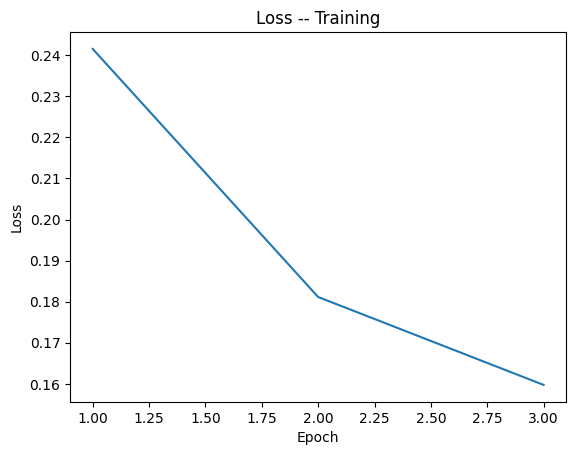

      -----  
-----       ------


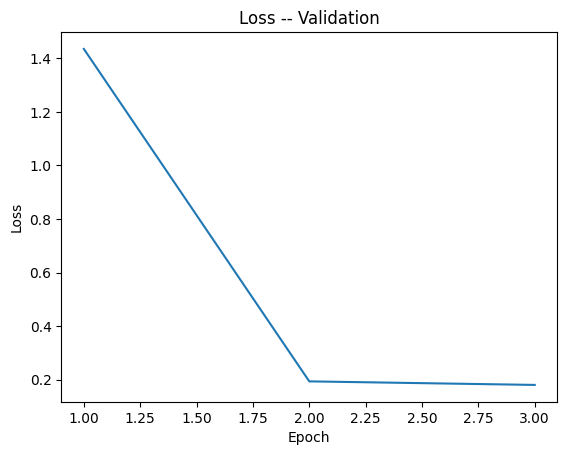

In [ ]:
import matplotlib.pyplot as plt

def plot_graph(loss_list, epoch_list, loss_type):
      loss_list_new = []
      for loss in loss_list:
          loss_list_new.append(loss.tolist())
      plt.plot(epoch_list, loss_list_new)
      plt.ylabel("Loss")
      plt.xlabel("Epoch")
      plt.title("Loss -- "+ loss_type)
      plt.show()

epoch_list = [1,2,3]
plot_graph(model.loss_each_epoch_training, epoch_list, "Training")
print("      -----  ")
print("-----       ------")
plot_graph(model.loss_each_epoch_testing[0:len(model.loss_each_epoch_testing)-1], epoch_list, "Validation")